### About 

This notebook showcases the results of the inundation emulator used in the Easter Sicily site demonstrator for PTF event evaluation. 

1. Setup before use
2. How to train the emulator
2. Usage of the emulator to generate predictions
3. Evaluation of the simulation and emulation results to generate quantile/percentile plots and depth exceedance plots



In [2]:
import os
ROOT_DIR = "/home/nrr/projects/inundation-emulator" # Change to the root directory of the project and uncomment this line
os.chdir(ROOT_DIR)

In [3]:
!pwd

/home/nrr/projects/inundation-emulator


In [4]:
from src.emulator import Emulator, DataReader
import tensorflow as tf
import netCDF4 as nc
from netCDF4 import Dataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colormaps 
from matplotlib import colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker


2025-08-13 16:53:09.285674: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 16:53:09.287577: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-13 16:53:09.291754: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-13 16:53:09.303245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755103989.322478 2742857 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755103989.32

Print structure of the encoder and decoder of the emulator


In [5]:
# Load pretrained emulator.
GENERATED_DIR = "./generated"
TRAIN_SCENARIOS = "./scenario.txt"
TRAIN_DIR = '/home/nrr/NGI/P/2022/02/20220296/Calculations/temp_emulator' #Not used, but kept for reference
TEST_SCENARIOS = './tests/data/scenarios.txt' #1066 event
TEST_DIR = "./tests/data"
RUNDIR = "./generated/emulator_20250516_073408" #model trained using about 4000 scenarios as described in report 6.4
EPOCH_CHECKPOINT = 300
POIS = range(30, 45) 
emulator = Emulator(GENERATED_DIR, RUNDIR, POIS)

W0000 00:00:1755103993.671459 2742857 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-08-13 16:53:14,931 - src.emulator - INFO - Encoder:


2025-08-13 16:53:14,948 - src.emulator - INFO - Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 15, 481, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 13, 479, 8)     │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 13, 479, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 239, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 235, 16)     │         1,920 │
├───────

2025-08-13 16:53:14,963 - src.emulator - INFO - Model: "sequential_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 418908)         │    27,229,020 │
├─────

Prediction mask highlights the area of inundation modelled by the emulated. This mask is derived from the training dataset 

In [6]:
emulator.topomask.shape

(2224, 912)

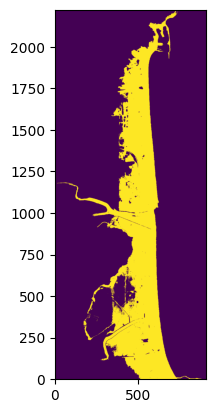

In [7]:
plt.imshow(emulator.topomask, origin='lower')

Contents of the prediction netcdf file (Maximum flow depth)

In [8]:
from pprint import pprint

def inspect_nc_file(file_path):
    # Open the NetCDF file
    dataset = Dataset(file_path, 'r')
    
    # Print general information about the dataset
    print(f"File: {file_path}")
    print(f"Dimensions:")
    pprint(dataset.dimensions)
    
    print(f"\nVariables:")
    pprint(dataset.variables)
    
    print(f"\nGlobal Attributes:")
    pprint(dataset.ncattrs())
    for attr in dataset.ncattrs():
        print(f"{attr}: {getattr(dataset, attr)}")
    
    # Close the dataset
    dataset.close()


Model used for deliverable 6.6 for PTF  

In [11]:
# Example usage
PREDICTION_DIR = "./generated/predictions/emulator_20250516_073408" 
file_path_pred = os.path.join(PREDICTION_DIR, "preds_20250516_142559", "PS_Scenario000001_CT_10m_PR.nc") 
file_path_true = "./tests/data/PS_Scenario000001_CT_10m.nc"
inspect_nc_file(file_path_pred)
print("..........................\n\n\n...........................\n")
inspect_nc_file(file_path_true)

File: ./generated/predictions/emulator_20250516_073408/preds_20250516_142559/PS_Scenario000001_CT_10m_PR.nc
Dimensions:
{'grid_lat': "<class 'netCDF4.Dimension'>": name = 'grid_lat', size = 2224,
 'grid_lon': "<class 'netCDF4.Dimension'>": name = 'grid_lon', size = 912,
 'lat': "<class 'netCDF4.Dimension'>": name = 'lat', size = 2224,
 'lon': "<class 'netCDF4.Dimension'>": name = 'lon', size = 912,
 'time': "<class 'netCDF4.Dimension'>": name = 'time', size = 2}

Variables:
{'grid_lat': <class 'netCDF4.Variable'>
float64 grid_lat(grid_lat)
    long_name: Grid latitude
    units: degrees
unlimited dimensions: 
current shape = (2224,)
filling on, default _FillValue of 9.969209968386869e+36 used,
 'grid_lon': <class 'netCDF4.Variable'>
float64 grid_lon(grid_lon)
    long_name: Grid longitude
    units: degrees
unlimited dimensions: 
current shape = (912,)
filling on, default _FillValue of 9.969209968386869e+36 used,
 'lat': <class 'netCDF4.Variable'>
float64 lat(lat)
    long_name: latitu

Reference event around which PTF ensemble was picked from the PTHA eventset.

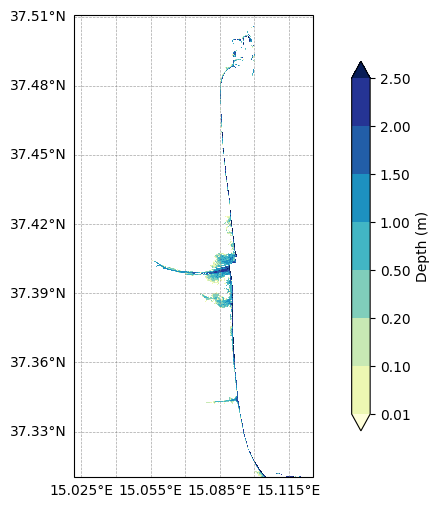

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib import colors
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import pandas as pd


# Load the netCDF file
file_path = "./tests/direct_simulation/grid3-catania_flowdepth.nc"  # Change to your actual file path
dataset = nc.Dataset(file_path)

# Extract variables
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
predicted = dataset.variables['z'][:]

#set 0 to nan 
true = np.where(predicted <= 0, np.nan, predicted)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot predicted values as a heatmap
cmap = cm.get_cmap('YlGnBu')
bounds = [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5]
norm = colors.BoundaryNorm(bounds, cmap.N, extend='both')
img = ax.pcolormesh(lon, lat, true, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation="vertical", shrink=0.8, pad=0.05)
cbar.set_label("Depth (m)")

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
gl.xformatter = cticker.LongitudeFormatter()
gl.yformatter = cticker.LatitudeFormatter()
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right labels

# Set axis labels
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add a title
# plt.title("Flow Depth For Test Event(Mw 8.05)", fontsize=12, fontweight="bold")

# Show the plot
plt.savefig("./notebooks/_plots/ReferenceEvent_flowdepth.png", dpi=300, bbox_inches='tight')
plt.show()

Evaluate PTF simulated inundation ensemble for quantile and depth plots

In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import pandas as pd

# Load the netCDF file
folder_path = "./tests/data" #loop through all scenario files like PS_Scenario000001_CT_10m.nc ending with _CT_10m.nc and compile a single netcdf with z values and their statistics at each lat/lon
files = [f for f in os.listdir(folder_path) if f.endswith('_CT_10m.nc')]
#sort files
files.sort()
topo_mask = './generated/emulator_20250516_073408/topomask.npy'
#load topomask
topomask = np.load(topo_mask)

#create empty arrays to store lat, lon, and z values, and append per scenario z
z_all = []

for file_path in files[:]:

    print(f"\rProcessing: {file_path}", end="", flush=True)


    full_path = os.path.join(folder_path, file_path)

    # Load the netCDF file
    dataset = nc.Dataset(full_path)

    # Extract variables
    if file_path == 'PS_Scenario000001_CT_10m.nc':
        #arrange lat and lon like z array
        lat = dataset.variables['lat'][:]
        lon = dataset.variables['lon'][:]
        lon2d, lat2d = np.meshgrid(lon, lat)
        lon_mask = lon2d[topomask]
        lat_mask = lat2d[topomask]

    z = dataset.variables['z'][:]
    # Close the dataset
    dataset.close()

    #append z values to z_all
    z_all.append(z[topomask])

# Convert list to NumPy array (shape: [n_scenarios, n_masked_points])
z_all = np.array(z_all)
#replace nan with 0
z_all = np.nan_to_num(z_all, nan=0.0)

quantiles = [0.01,0.05, 0.16, 0.5,0.6,0.8, 0.84,0.9, 0.95,0.99]

zQuantiles = np.quantile(z_all, quantiles, axis=0)

#get percentage of values greater than depths at each z point
depths = [0.01, 0.2, 0.5, 1, 1.5, 2, 2.5, 4]
depths = np.array(depths)
depths_percentage = np.zeros((len(depths), z_all.shape[1]))
for i, depth in enumerate(depths):
    depths_percentage[i] = np.sum(z_all > depth, axis=0) / z_all.shape[0] * 100



Processing: PS_Scenario000001_CT_10m.nc

Save to file

In [ ]:
#save to csv
table = pd.DataFrame(list(zip(lon_mask, lat_mask, *zQuantiles)))
table.columns = ['lon', 'lat'] + [f'q{int(q*100)}' for q in quantiles]
table.to_csv('./generated/predictions/emulator_20250516_073408/preds_20250516_142559/z_quantiles.csv', index=False)

table_depths = pd.DataFrame(list(zip(lon_mask, lat_mask, *depths_percentage)))
table_depths.columns = ['lon', 'lat'] + [f'depth_{depth}' for depth in depths]
table_depths.to_csv('./generated/predictions/emulator_20250516_073408/preds_20250516_142559/z_percentage.csv', index=False)


PTF Emulation Ensemble

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import pandas as pd

# Load the netCDF file
folder_path = "./generated/predictions/emulator_20250516_073408/preds_20250516_142559" #loop through all scenario files like PS_Scenario000001_CT_10m.nc ending with _CT_10m.nc and compile a single netcdf with z values and their statistics at each lat/lon
files = [f for f in os.listdir(folder_path) if f.endswith('_CT_10m_PR.nc')]
#sort files
files.sort()

topo_mask = './generated/emulator_20250516_073408/topomask.npy'
#load topomask
topomask = np.load(topo_mask)

#create empty arrays to store lat, lon, and z values, and append per scenario z
zhat_all = []

for file_path in files[:]:

    print(f"\rProcessing: {file_path}", end="", flush=True)


    full_path = os.path.join(folder_path, file_path)

    # Load the netCDF file
    dataset = nc.Dataset(full_path)

    # Extract variables
    if file_path == 'PS_Scenario000001_CT_10m.nc':
        #arrange lat and lon like z array
        lat = dataset.variables['lat'][:]
        lon = dataset.variables['lon'][:]
        lon2d, lat2d = np.meshgrid(lon, lat)
        lon_mask = lon2d[topomask]
        lat_mask = lat2d[topomask]

    zhat = dataset.variables['predicted'][:]
    # Close the dataset
    dataset.close()

    #append z values to zhat_all
    zhat_all.append(zhat[topomask])

# Convert list to NumPy array (shape: [n_scenarios, n_masked_points])
zhat_all = np.array(zhat_all)
#replace nan with 0
zhat_all = np.nan_to_num(zhat_all, nan=0.0)

#get some statistics like 0.5, 0.16, median(0.5), 0.84, 0.95
quantiles = [0.01,0.05, 0.16, 0.5,0.6,0.8, 0.84,0.9, 0.95,0.99]

zhatQuantiles = np.quantile(zhat_all, quantiles, axis=0)

#get percentage of values greater than depths at each z point
depths = [0.01, 0.2, 0.5, 1, 1.5, 2, 2.5, 4]
depths = np.array(depths)
depthshat_percentage = np.zeros((len(depths), zhat_all.shape[1]))
for i, depth in enumerate(depths):
    depthshat_percentage[i] = np.sum(zhat_all > depth, axis=0) / zhat_all.shape[0] * 100


Processing: PS_Scenario000001_CT_10m_PR.nc

In [ ]:
#save to csv
table = pd.DataFrame(list(zip(lon_mask, lat_mask, *zhatQuantiles)))
table.columns = ['lon', 'lat'] + [f'q{int(q*100)}' for q in quantiles]
table.to_csv('./generated/predictions/emulator_20250516_073408/preds_20250516_142559/zhat_quantiles.csv', index=False)

table_depths = pd.DataFrame(list(zip(lon_mask, lat_mask, *depthshat_percentage)))
table_depths.columns = ['lon', 'lat'] + [f'depth_{depth}' for depth in depths]
table_depths.to_csv('./generated/predictions/emulator_20250516_073408/preds_20250516_142559/zhat_percentage.csv', index=False)


Comparison of emulated and simulated inundation for a single ensemble member or scenario

plotting event: [0]

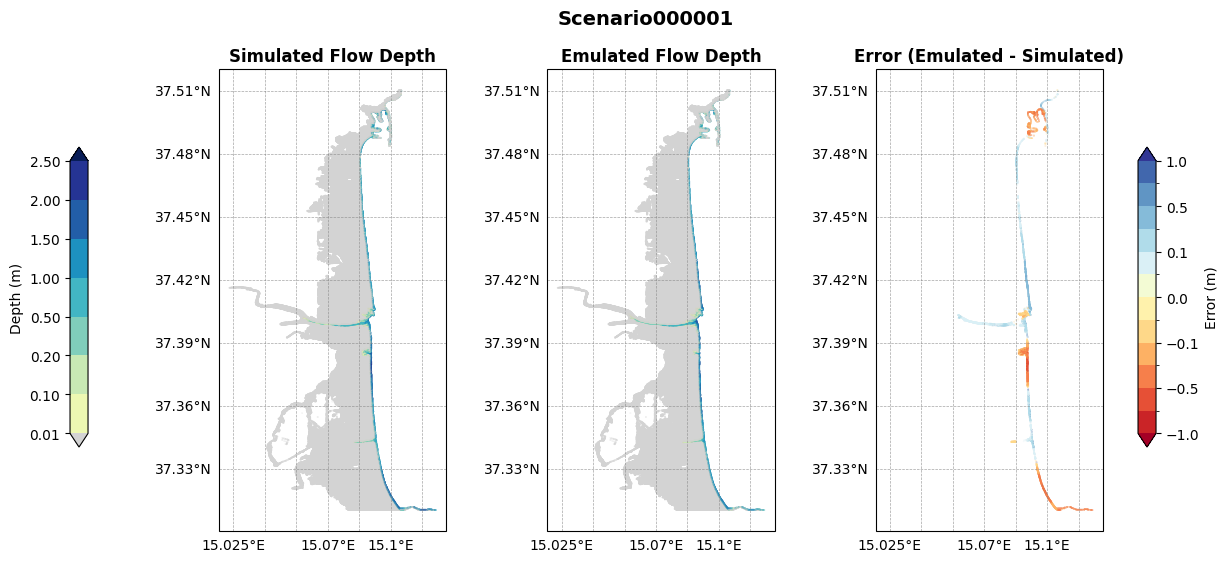

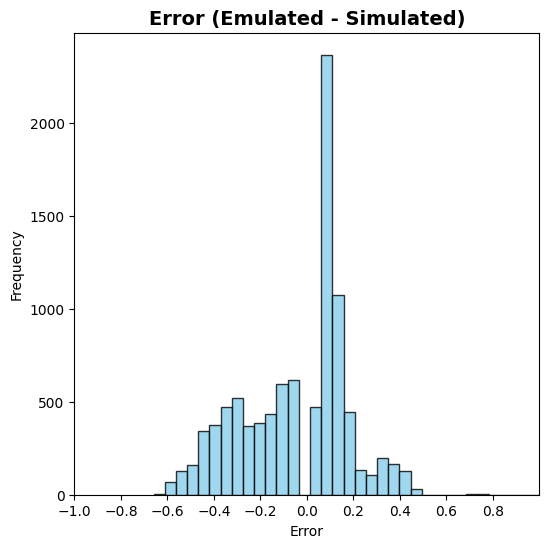

In [61]:
i = 0  # Index of the event to plot
print(f"plotting event: {[i]}", end="", flush=True)

# Define shared coordinates
z_sim = z_all[i]
z_emul = zhat_all[i]
error = z_emul - z_sim  # Error map
#id err is withing 1 % set to nan
error[np.abs(error) <= 0.05] = np.nan

# Setup figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

#plot the lat, lon, and z values as map
depth_cmap = colormaps['YlGnBu']
bounds = [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5]
depth_cmap.set_under('lightgrey')  # Set color for values below the first bound
depth_norm = colors.BoundaryNorm(bounds, depth_cmap.N, extend='both')

error_cmap = colormaps['RdYlBu']
error_bounds = [-1, -0.75, -0.5, -0.25, -0.1, -0.05, 0, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
error_norm = colors.BoundaryNorm(error_bounds, error_cmap.N, extend='both')


# --- Plot 1: Simulated ---
sc0 = axs[0].scatter(lon_mask, lat_mask, c=z_sim, cmap=depth_cmap, norm=depth_norm, s=0.01, transform=ccrs.PlateCarree())
axs[0].set_title(f"Simulated Flow Depth", fontsize=12, fontweight="bold")
gl0 = axs[0].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
gl0.top_labels = gl0.right_labels = False
gl0.xformatter = cticker.LongitudeFormatter()
gl0.yformatter = cticker.LatitudeFormatter()

# --- Plot 2: Emulated ---
sc1 = axs[1].scatter(lon_mask, lat_mask, c=z_emul, cmap=depth_cmap, norm=depth_norm, s=0.01, transform=ccrs.PlateCarree())
axs[1].set_title("Emulated Flow Depth", fontsize=12, fontweight="bold")
gl1 = axs[1].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
gl1.top_labels = gl1.right_labels = False
gl1.xformatter = cticker.LongitudeFormatter()
gl1.yformatter = cticker.LatitudeFormatter()

# --- Plot 3: Error ---
sc2 = axs[2].scatter(lon_mask, lat_mask, c=error, cmap=error_cmap, norm=error_norm, s=0.01, transform=ccrs.PlateCarree())
axs[2].set_title("Error (Emulated - Simulated)", fontsize=12, fontweight="bold")
gl2 = axs[2].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
gl2.top_labels = gl2.right_labels = False
gl2.xformatter = cticker.LongitudeFormatter()
gl2.yformatter = cticker.LatitudeFormatter()

# --- Colorbars ---
# Depth (m) colorbar on the left of first subplot
cbar_ax1 = fig.add_axes([0.02, 0.25, 0.015, 0.5])  
cbar1 = fig.colorbar(sc1, cax=cbar_ax1)
cbar1.set_label('Depth (m)')
cbar1.ax.yaxis.set_label_position('left')
cbar1.ax.yaxis.set_ticks_position('left')

# Error (m) colorbar on the right of last subplot
cbar_ax2 = fig.add_axes([0.91, 0.25, 0.015, 0.5])
cbar2 = fig.colorbar(sc2, cax=cbar_ax2)
cbar2.set_label('Error (m)')
plt.suptitle(f"{files[i][3:-13]}", fontsize=14, fontweight="bold")
plt.show()

#plot for error atleast +-1cm
fig, ax = plt.subplots(figsize=(6, 6))
error_filter = error[np.abs(error) >= 0.01]
plt.hist(error_filter, bins=50,color='skyblue',edgecolor='black',alpha=0.8)
plt.xlim(-1, 1)
plt.xticks(np.arange(-1, 1, 0.2))
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error (Emulated - Simulated)", fontsize=14, fontweight="bold")
plt.show()

Comparison plots for different quantiles

In [ ]:
#lat lon of prediction locations
latmask = np.array(pd.read_csv('./generated/predictions/emulator_20250516_073408/preds_20250516_142559/z_quantiles.csv')['lat'])
lonmask = np.array(pd.read_csv('./generated/predictions/emulator_20250516_073408/preds_20250516_142559/z_quantiles.csv')['lon'])

#read quantile depth files
zQuantiles = pd.read_csv('./generated/predictions/emulator_20250516_073408/preds_20250516_142559/z_quantiles.csv').iloc[:,2:]
zhatQuantiles = pd.read_csv('./generated/predictions/emulator_20250516_073408/preds_20250516_142559/zhat_quantiles.csv').iloc[:,2:]

# #read perc exceeding depth file
depths_percentage = pd.read_csv('./generated/predictions/emulator_20250516_073408/preds_20250516_142559/z_percentage.csv').iloc[:,2:]
depthshat_percentage = pd.read_csv('./generated/predictions/emulator_20250516_073408/preds_20250516_142559/zhat_percentage.csv').iloc[:,2:]

quantiles = [0.01,0.05, 0.16, 0.5,0.6,0.8, 0.84,0.9, 0.95,0.99]
depths = [0.01, 0.2, 0.5, 1, 1.5, 2, 2.5, 4]

plotting for Q:0.01

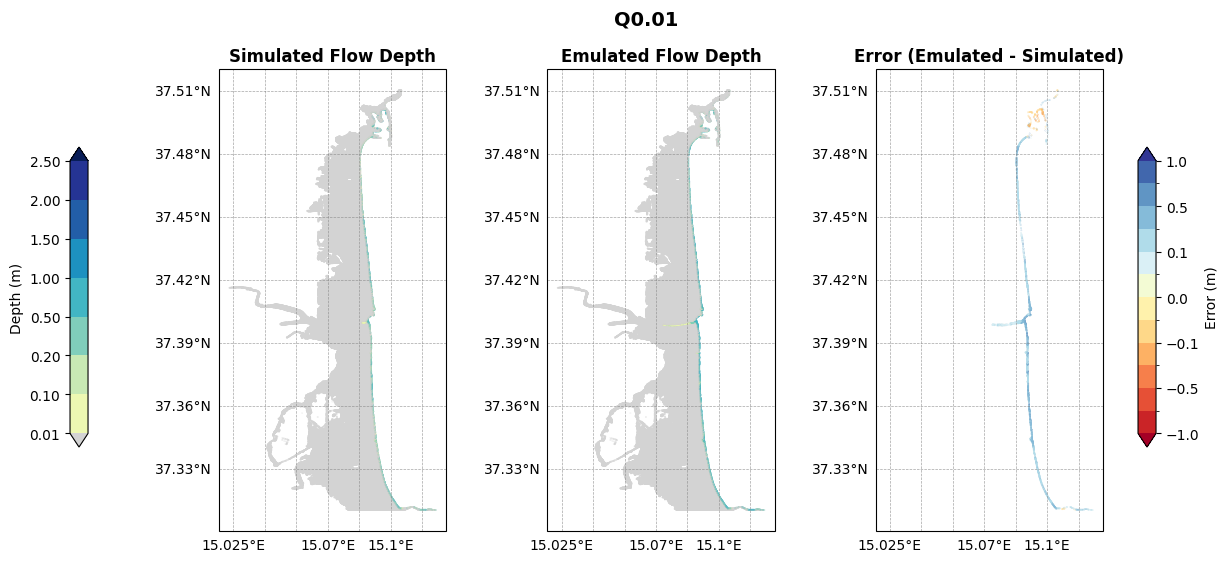

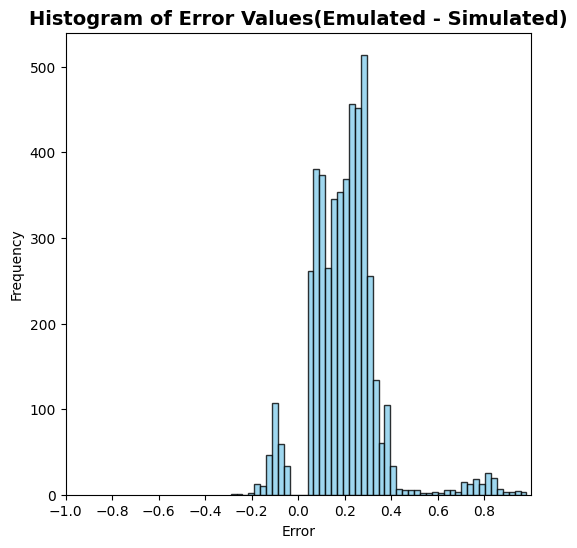

plotting for Q:0.05

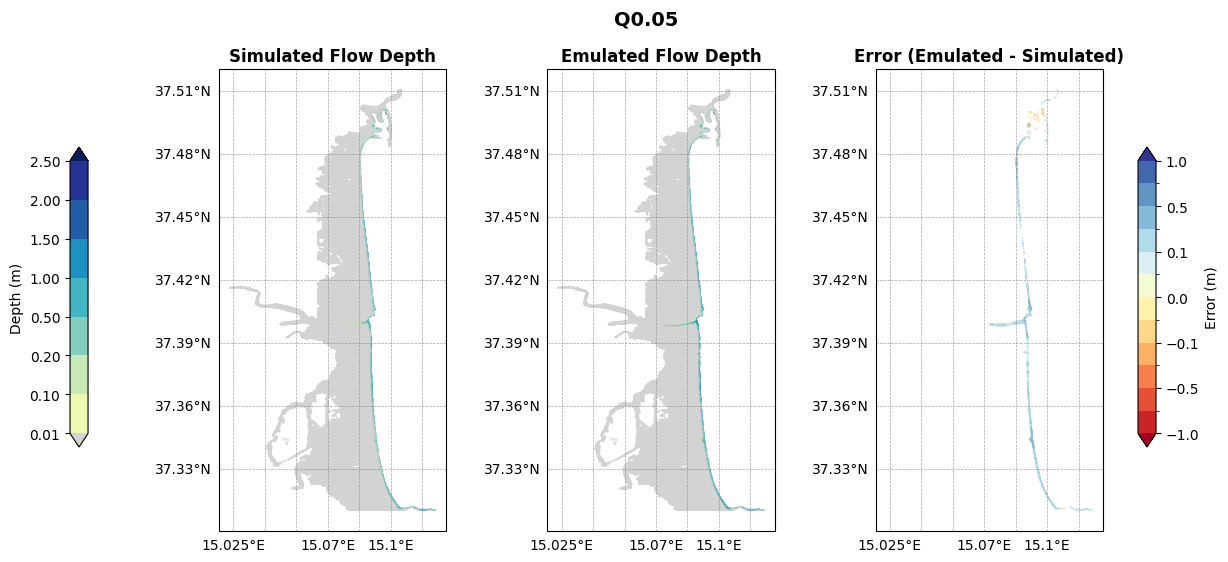

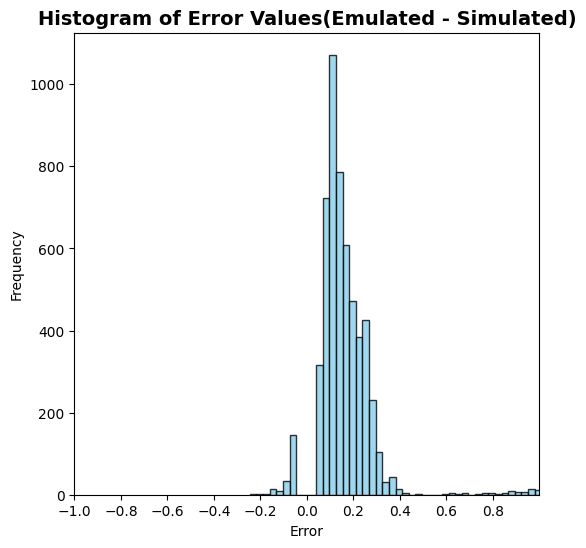

plotting for Q:0.16

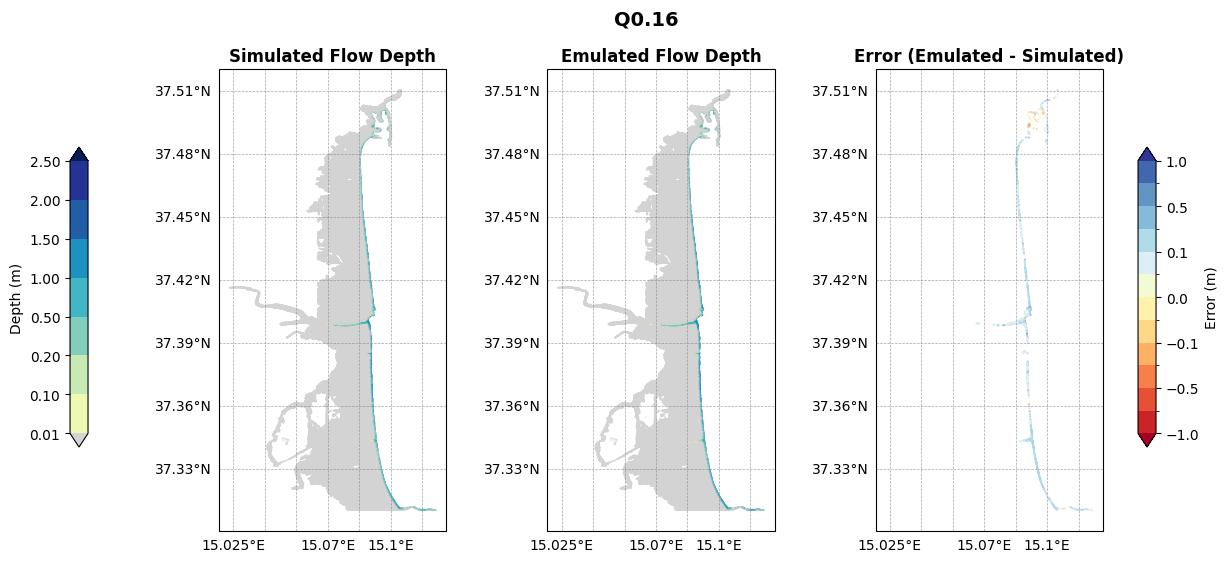

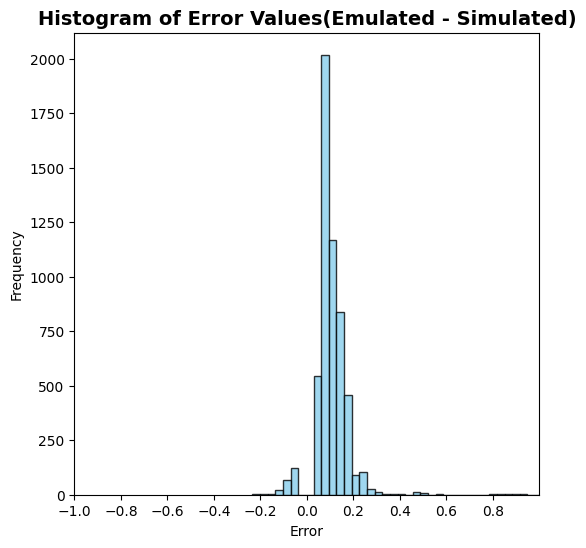

plotting for Q:0.5

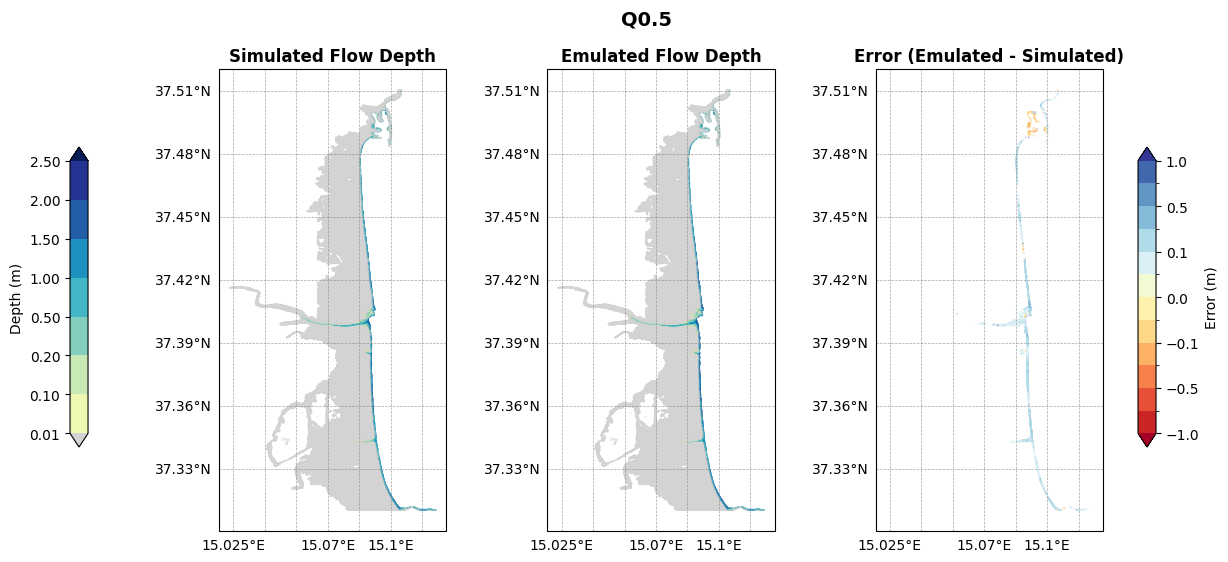

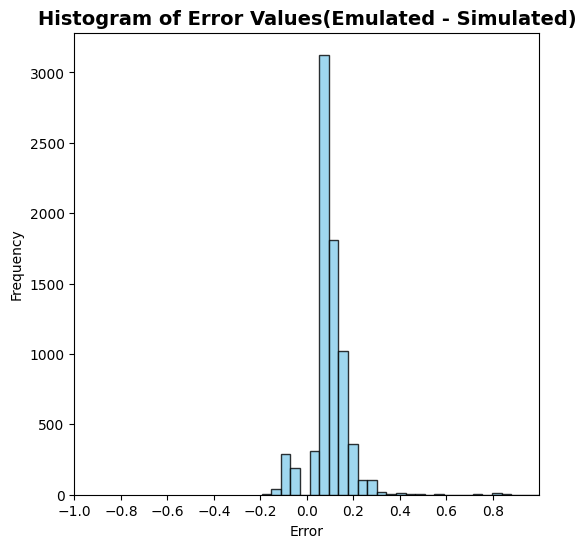

plotting for Q:0.6

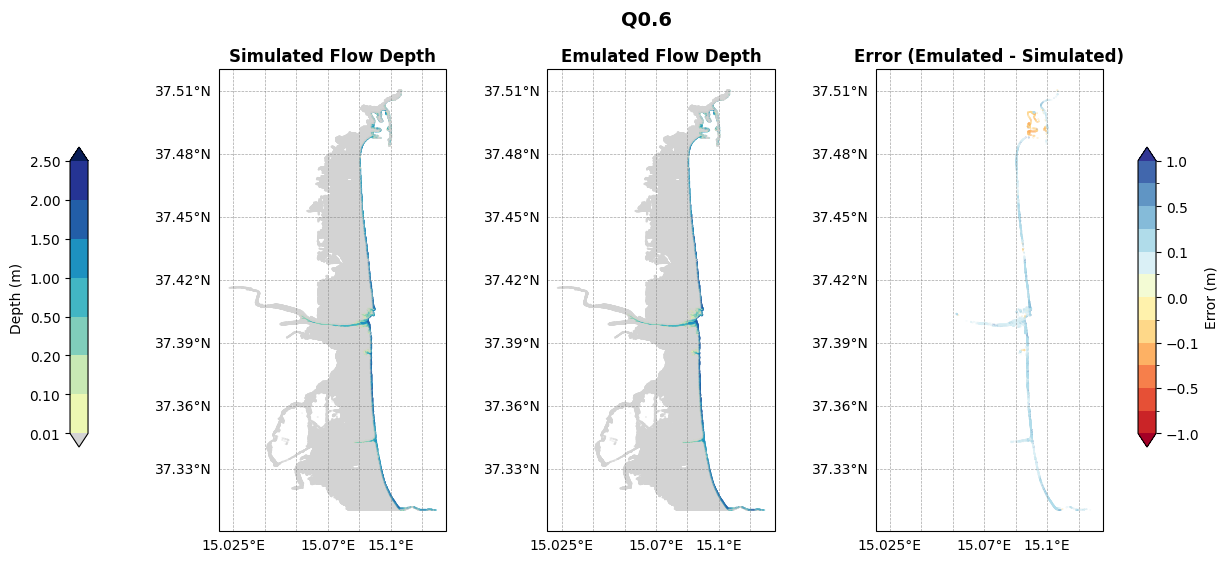

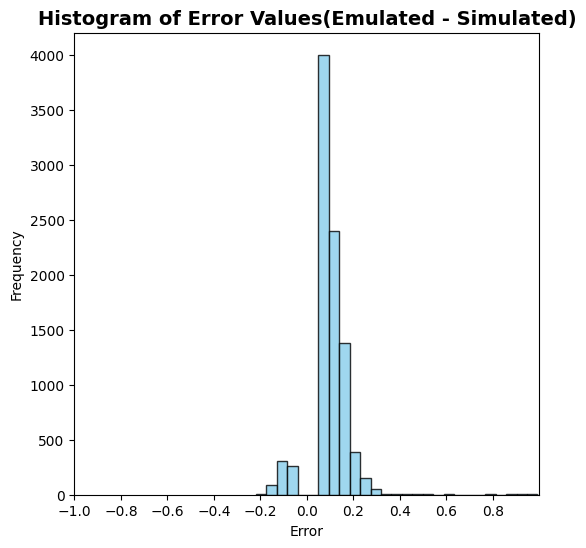

plotting for Q:0.8

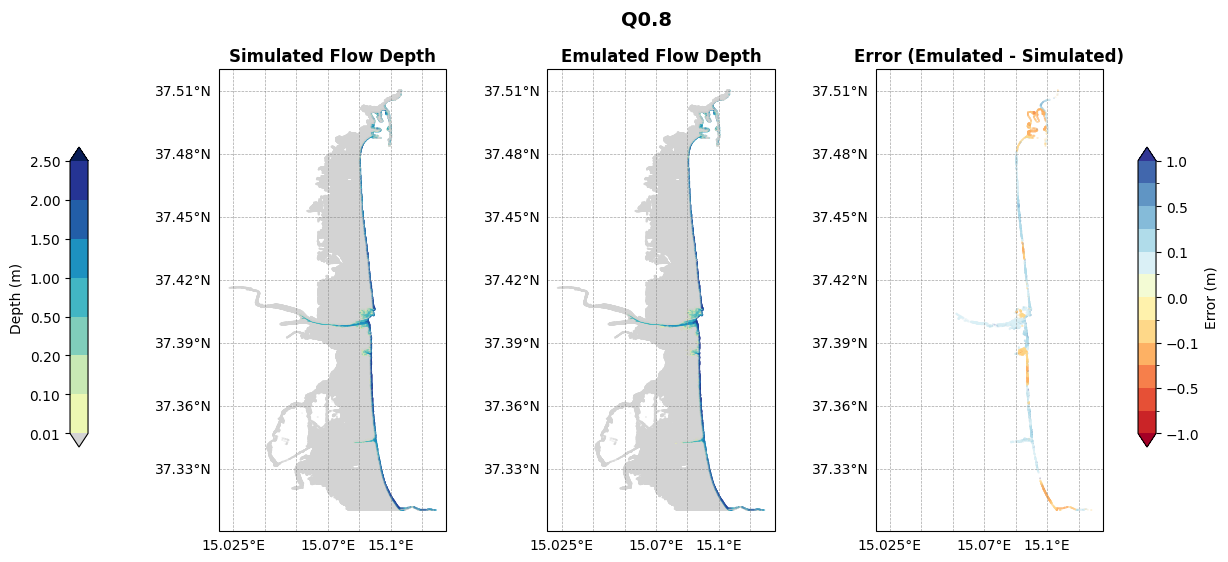

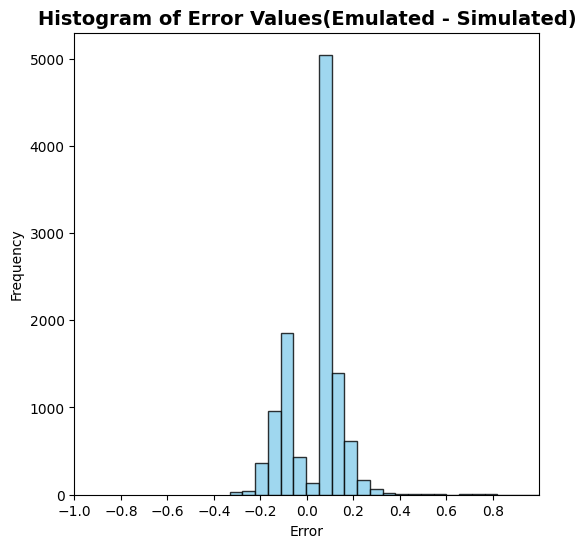

plotting for Q:0.84

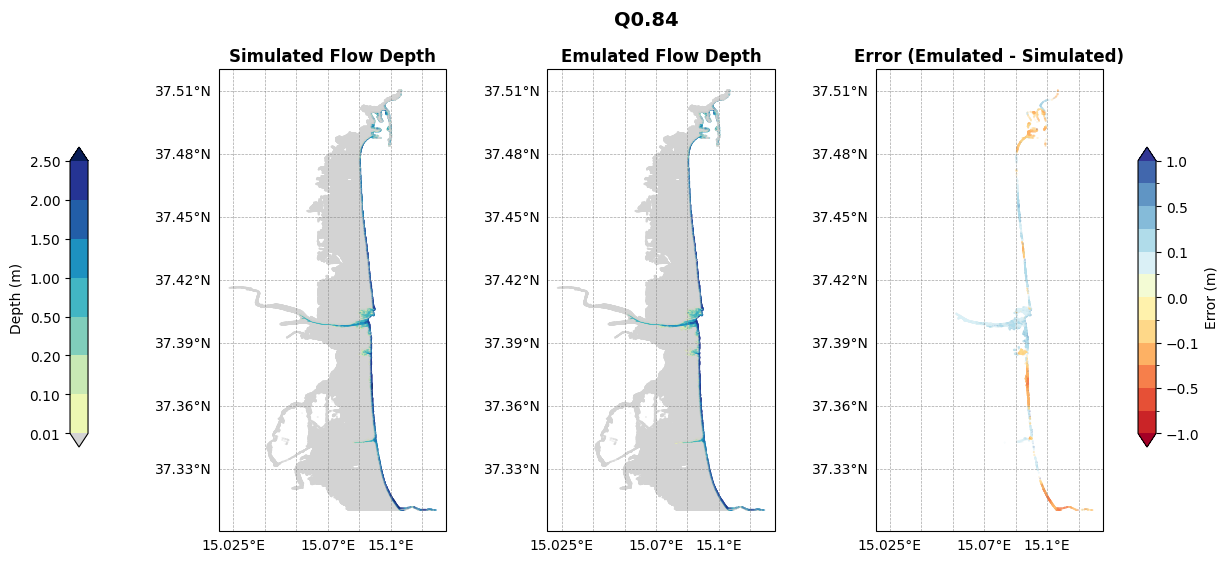

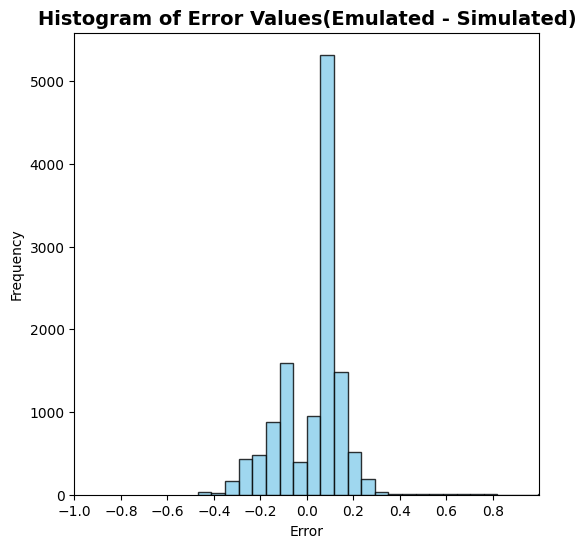

plotting for Q:0.9

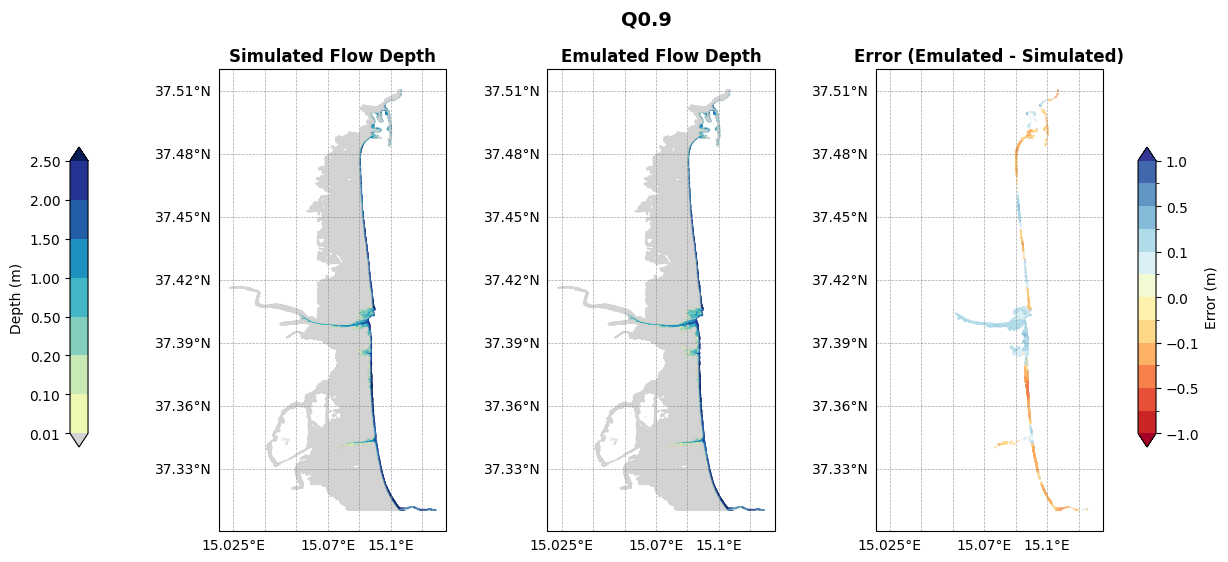

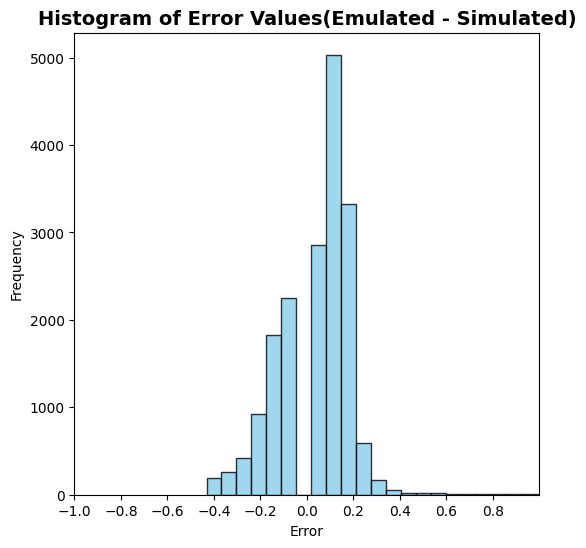

plotting for Q:0.95

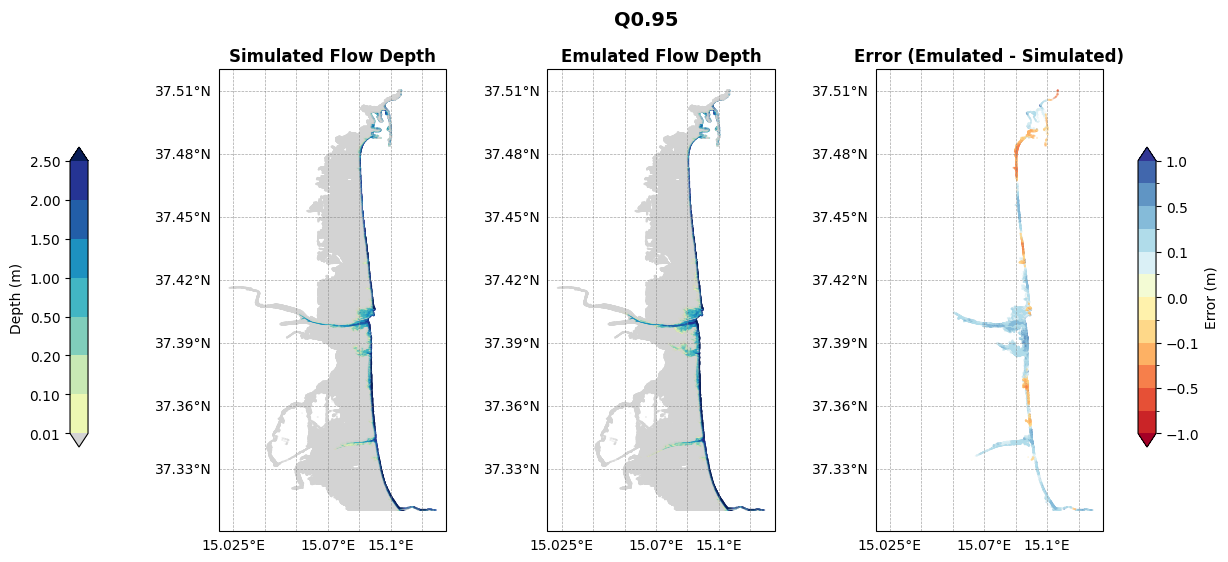

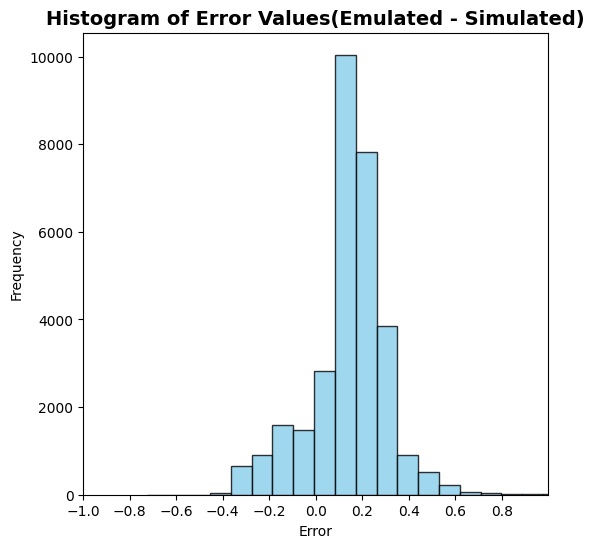

plotting for Q:0.99

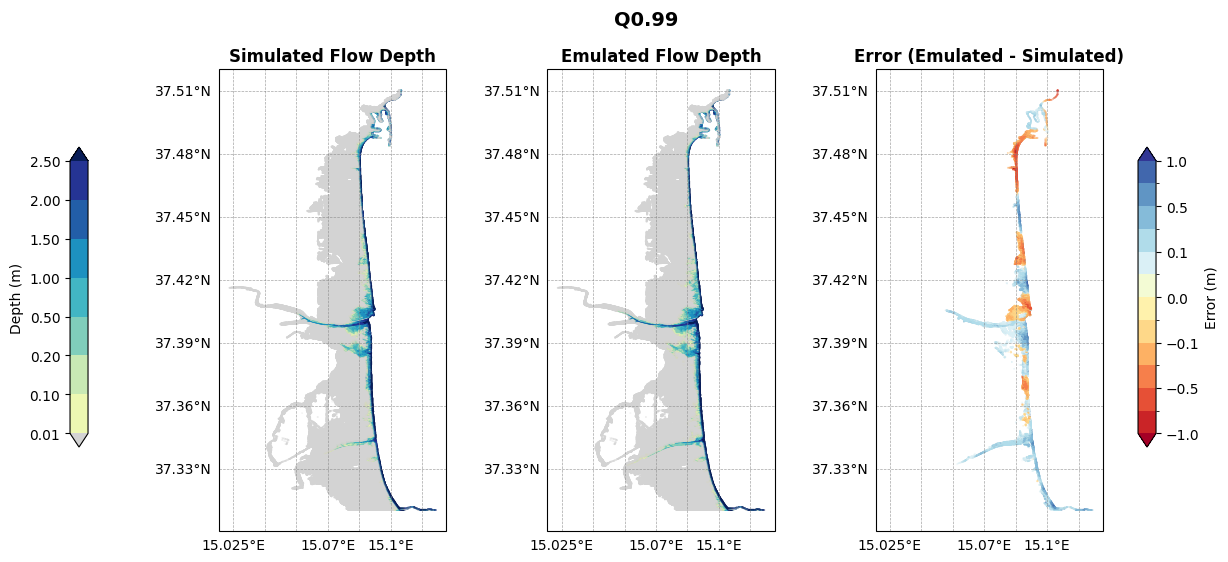

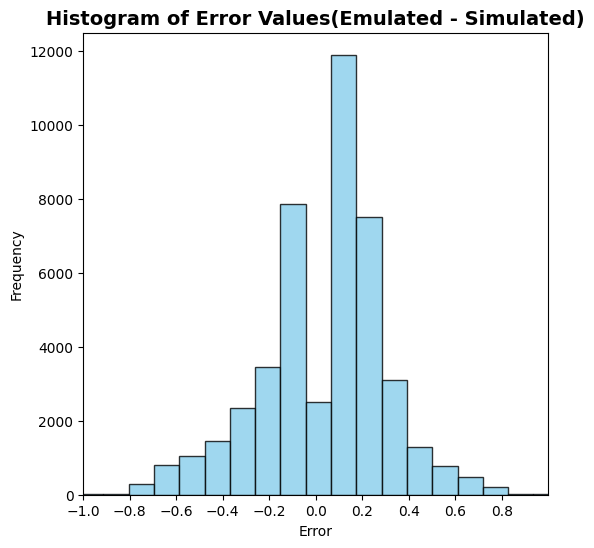

In [56]:
#plot the lat, lon, and z values as map
depth_cmap = colormaps['YlGnBu']
bounds = [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5]
depth_cmap.set_under('lightgrey')  # Set color for values below the first bound
depth_norm = colors.BoundaryNorm(bounds, depth_cmap.N, extend='both')

error_cmap = colormaps['RdYlBu']
error_bounds = [-1, -0.75, -0.5, -0.25, -0.1, -0.05, 0, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
error_norm = colors.BoundaryNorm(error_bounds, error_cmap.N, extend='both')

for i in range(len(quantiles)):
    print(f"plotting for Q:{quantiles[i]}", end="", flush=True)

    # Define shared coordinates
    z_sim = zQuantiles.iloc[:,i].values
    z_emul = zhatQuantiles.iloc[:,i].values
    error = z_emul - z_sim  # Error map
    #id err is withing 1 % set to nan
    error[np.abs(error) <= 0.05] = np.nan

    # Setup figure and subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # --- Plot 1: Simulated ---
    sc0 = axs[0].scatter(lon_mask, lat_mask, c=z_sim, cmap=depth_cmap, norm=depth_norm, s=0.01, transform=ccrs.PlateCarree())
    axs[0].set_title(f"Simulated Flow Depth", fontsize=12, fontweight="bold")
    gl0 = axs[0].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
    gl0.top_labels = gl0.right_labels = False
    gl0.xformatter = cticker.LongitudeFormatter()
    gl0.yformatter = cticker.LatitudeFormatter()

    # --- Plot 2: Emulated ---
    sc1 = axs[1].scatter(lon_mask, lat_mask, c=z_emul, cmap=depth_cmap, norm=depth_norm, s=0.01, transform=ccrs.PlateCarree())
    axs[1].set_title("Emulated Flow Depth", fontsize=12, fontweight="bold")
    gl1 = axs[1].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
    gl1.top_labels = gl1.right_labels = False
    gl1.xformatter = cticker.LongitudeFormatter()
    gl1.yformatter = cticker.LatitudeFormatter()

    # --- Plot 3: Error ---
    sc2 = axs[2].scatter(lon_mask, lat_mask, c=error, cmap=error_cmap, norm=error_norm, s=0.01, transform=ccrs.PlateCarree())
    axs[2].set_title("Error (Emulated - Simulated)", fontsize=12, fontweight="bold")
    gl2 = axs[2].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
    gl2.top_labels = gl2.right_labels = False
    gl2.xformatter = cticker.LongitudeFormatter()
    gl2.yformatter = cticker.LatitudeFormatter()

    # --- Colorbars ---
    # Depth (m) colorbar on the left of first subplot
    cbar_ax1 = fig.add_axes([0.02, 0.25, 0.015, 0.5])  
    cbar1 = fig.colorbar(sc1, cax=cbar_ax1)
    cbar1.set_label('Depth (m)')
    cbar1.ax.yaxis.set_label_position('left')
    cbar1.ax.yaxis.set_ticks_position('left')

    # Error (m) colorbar on the right of last subplot
    cbar_ax2 = fig.add_axes([0.91, 0.25, 0.015, 0.5])
    cbar2 = fig.colorbar(sc2, cax=cbar_ax2)
    cbar2.set_label('Error (m)')

    plt.suptitle(f"Q{quantiles[i]}", fontsize=14, fontweight="bold")
    plt.savefig(f"./notebooks/_plots/plot_Q{quantiles[i]}.png", bbox_inches='tight', dpi=300)
    plt.show()

    #plot for error atleast +-1cm
    fig, ax = plt.subplots(figsize=(6, 6))
    error_filter = error[np.abs(error) >= 0.01]
    plt.hist(error_filter, bins=50,color='skyblue',edgecolor='black',alpha=0.8)
    plt.xlim(-1, 1)
    plt.xticks(np.arange(-1, 1, 0.2))
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.title("Histogram of Error Values(Emulated - Simulated)", fontsize=14, fontweight="bold")
    plt.show()

Percentage of inundated maps

plotting for Depth:0.01

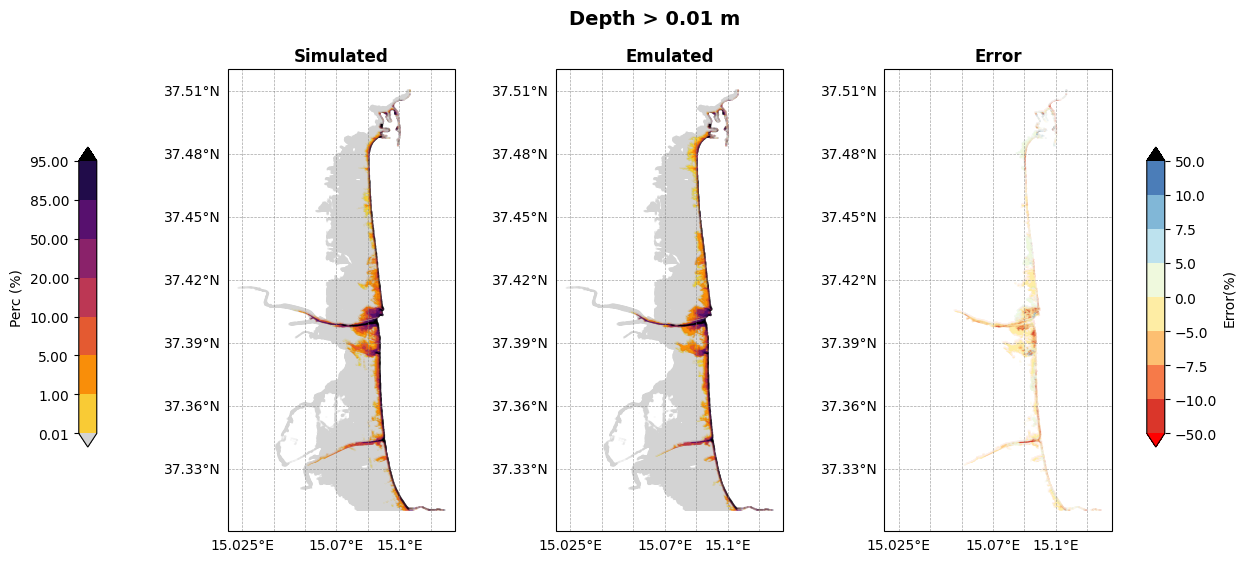

plotting for Depth:0.2

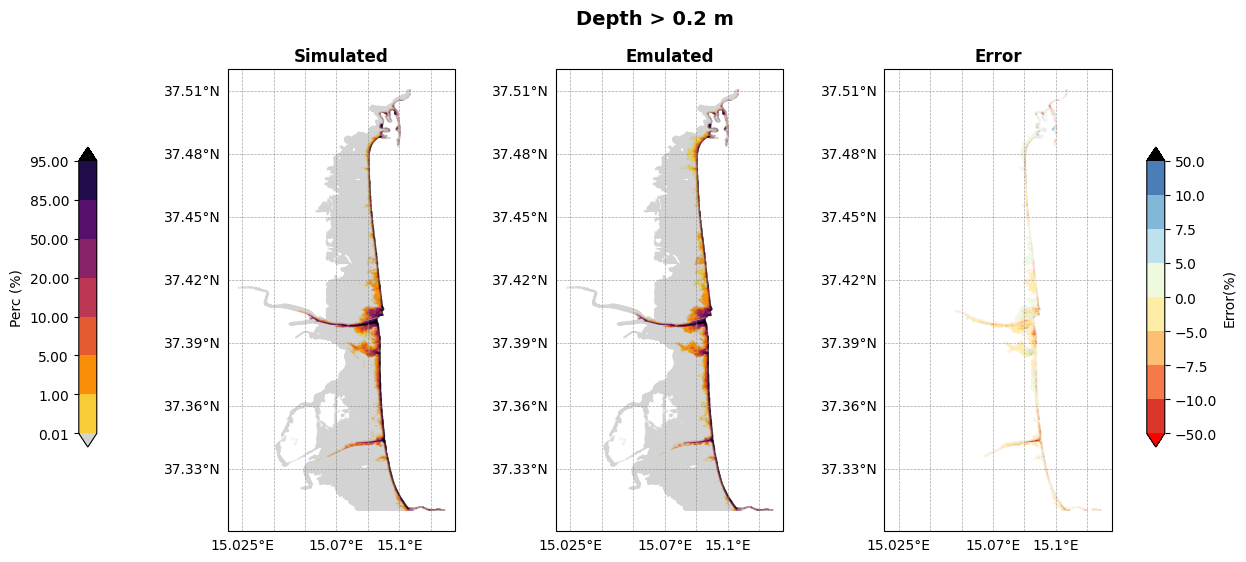

plotting for Depth:0.5

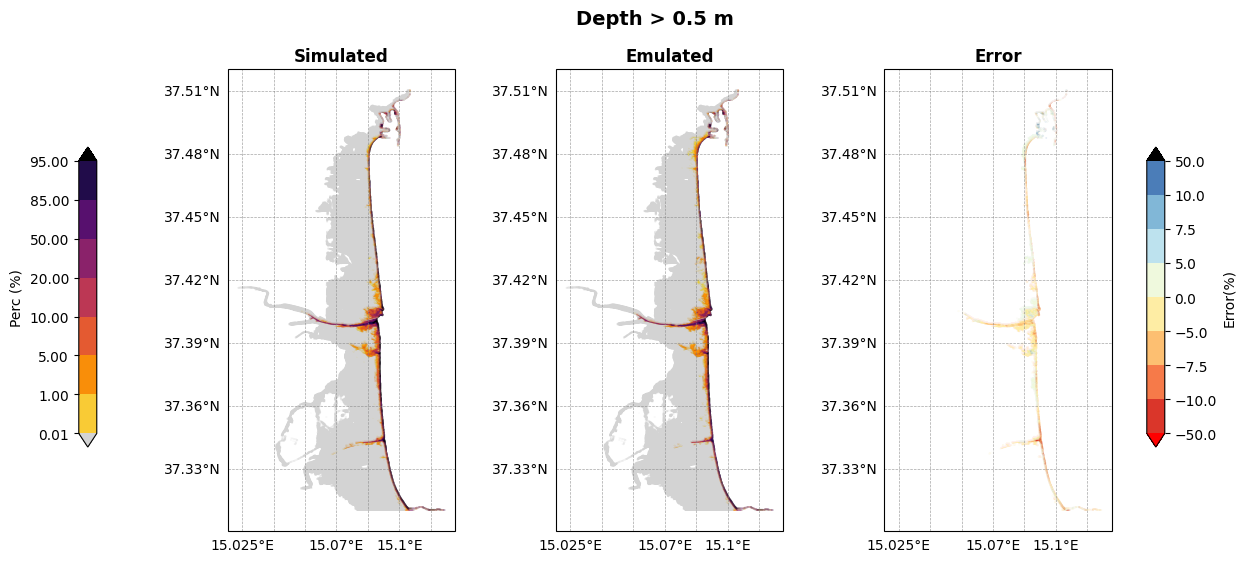

plotting for Depth:1

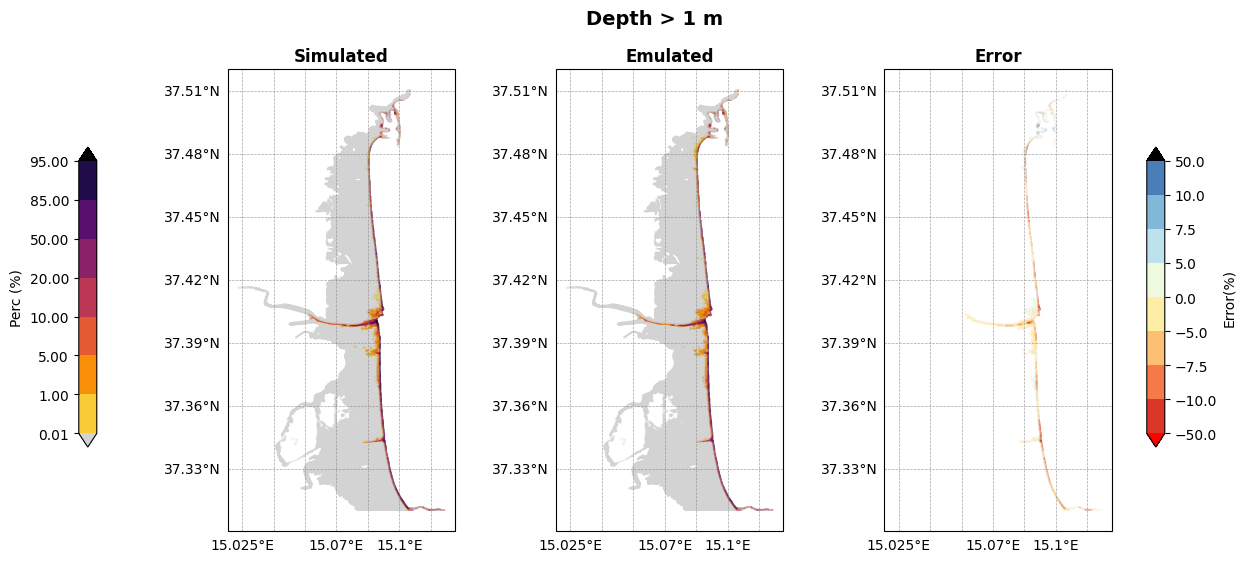

plotting for Depth:2.5

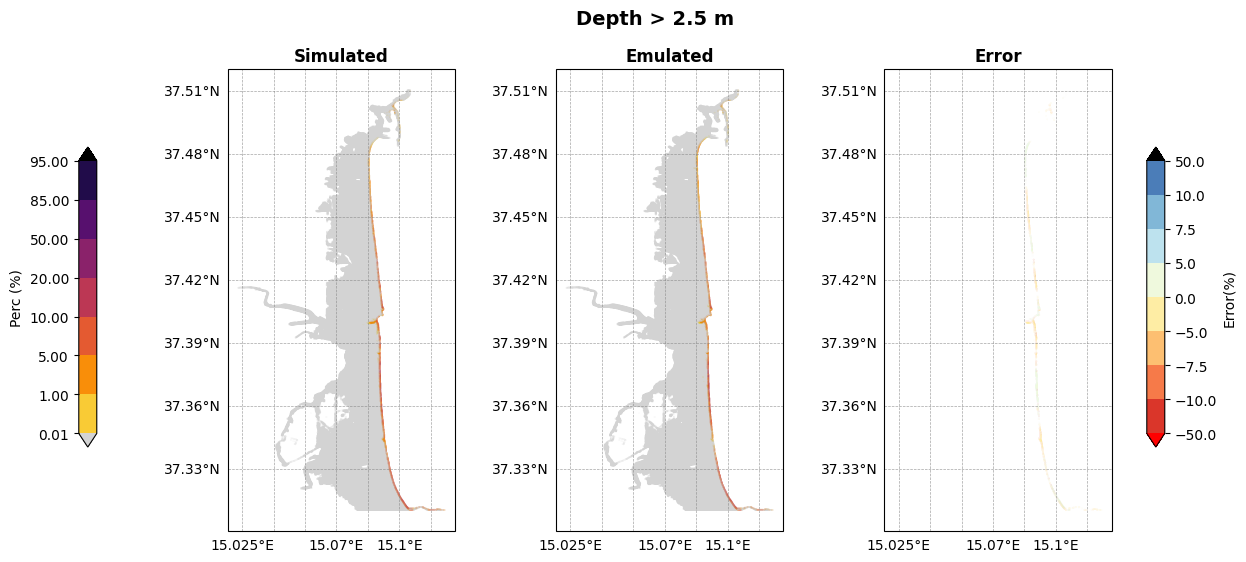

plotting for Depth:4

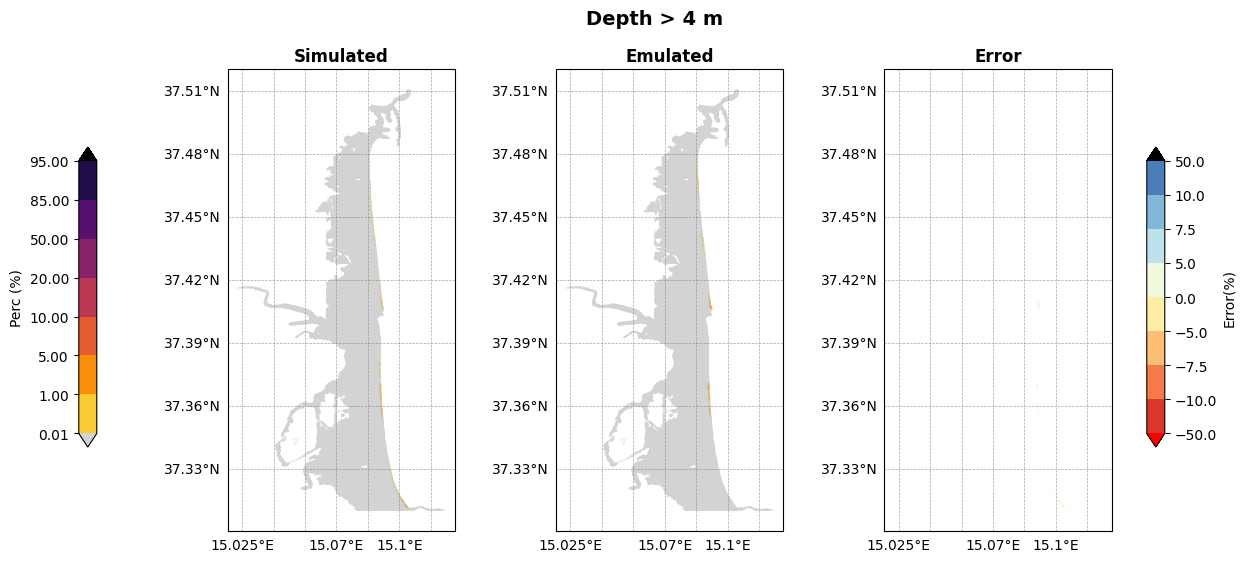

In [ ]:
#plot the lat, lon, and z values as map
thresholds = [0.01, 0.2, 0.5,1,2.5,4]

# Plot predicted values as a heatmap
depth_cmap = colormaps['inferno_r']
depth_cmap.set_under('lightgrey')  # Set color for values below the minimum bound
depth_cmap.set_over('black')  # Set color for values above the maximum bound
depth_cmap.set_bad('white')  # Set color for NaN values
bounds = [0.01, 1, 5, 10 , 20, 50, 85, 95]
percnorm = colors.BoundaryNorm(bounds, depth_cmap.N, extend='both')

error_cmap = colormaps['RdYlBu']
error_bounds = [ -50, -10, -7.5, -5, 0, 5, 7.5, 10, 50]
error_cmap.set_under('red')  # Set color for values below the minimum bound
error_cmap.set_over('black')  # Set color for values above the maximum bound
error_cmap.set_bad('white')  # Set color for NaN values
error_norm = colors.BoundaryNorm(error_bounds, error_cmap.N, extend='both')

for i in range(len(thresholds)):
    print(f"plotting for Depth:{thresholds[i]}", end="", flush=True)

    index = np.where(depths == thresholds[i])[0]  # Get the index of the threshold depth

    # Define shared coordinates
    z_sim = depthshat_percentage[index]
    z_emul = depths_percentage[index]
    error = z_emul - z_sim  # Error map

    #id err is withing 1 % set to nan
    error[np.abs(error) <= 1] = np.nan

    # Setup figure and subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # --- Plot 1: Simulated ---
    sc0 = axs[0].scatter(lon_mask, lat_mask, c=z_sim, cmap=depth_cmap, norm=percnorm, s=0.001,  transform=ccrs.PlateCarree())
    axs[0].set_title(f"Simulated", fontsize=12, fontweight="bold")
    gl0 = axs[0].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
    gl0.top_labels = gl0.right_labels = False
    gl0.xformatter = cticker.LongitudeFormatter()
    gl0.yformatter = cticker.LatitudeFormatter()

    # --- Plot 2: Emulated ---
    sc1 = axs[1].scatter(lon_mask, lat_mask, c=z_emul, cmap=depth_cmap, norm=percnorm, s=0.001, transform=ccrs.PlateCarree())
    axs[1].set_title("Emulated", fontsize=12, fontweight="bold")
    gl1 = axs[1].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
    gl1.top_labels = gl1.right_labels = False
    gl1.xformatter = cticker.LongitudeFormatter()
    gl1.yformatter = cticker.LatitudeFormatter()

    # --- Plot 3: Error ---
    sc2 = axs[2].scatter(lon_mask, lat_mask, c=error,cmap= error_cmap, norm=error_norm, s=0.001, transform=ccrs.PlateCarree())
    axs[2].set_title("Error", fontsize=12, fontweight="bold")
    gl2 = axs[2].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
    gl2.top_labels = gl2.right_labels = False
    gl2.xformatter = cticker.LongitudeFormatter()
    gl2.yformatter = cticker.LatitudeFormatter()

    # --- Colorbars ---
    # Depth (m) colorbar on the left of first subplot
    cbar_ax1 = fig.add_axes([0.02, 0.25, 0.015, 0.5])  
    cbar1 = fig.colorbar(sc1, cax=cbar_ax1)
    cbar1.set_label('Perc (%)')
    cbar1.ax.yaxis.set_label_position('left')
    cbar1.ax.yaxis.set_ticks_position('left')

    # Error (m) colorbar on the right of last subplot
    cbar_ax2 = fig.add_axes([0.91, 0.25, 0.015, 0.5])
    cbar2 = fig.colorbar(sc2, cax=cbar_ax2)
    cbar2.set_label('Error(%)')
    
    plt.suptitle(f"Depth > {thresholds[i]} m", fontsize=14, fontweight="bold")
    plt.savefig(f"./notebooks/_plots/plot_depth_{thresholds[i]}.png", bbox_inches='tight',dpi=300)

    plt.show()

plotting for Depth:0.01

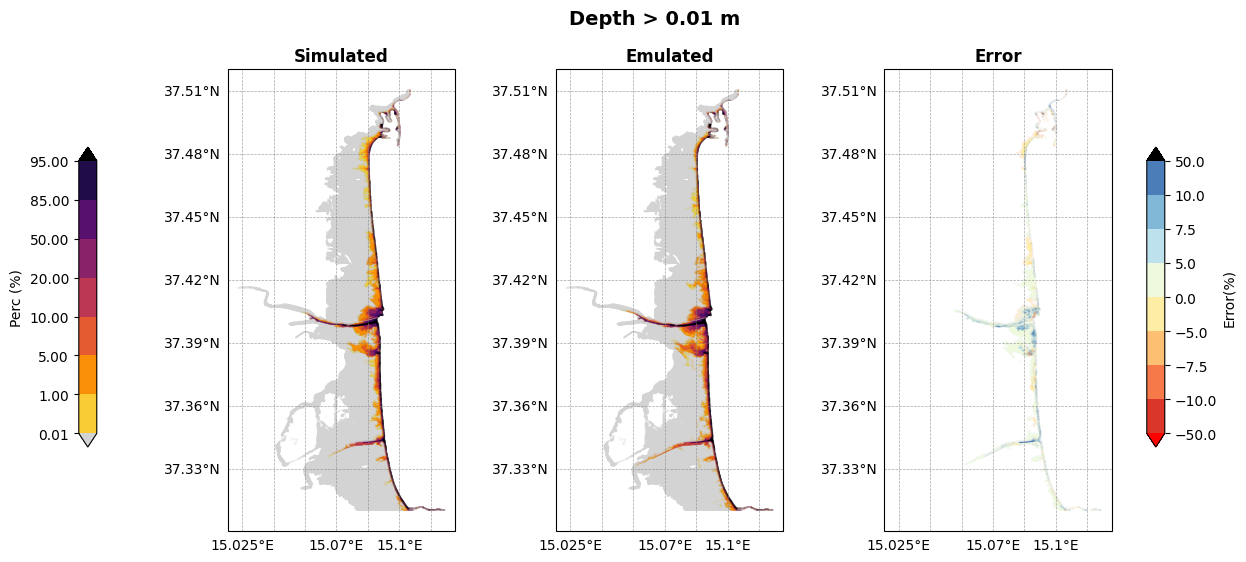

plotting for Depth:0.2

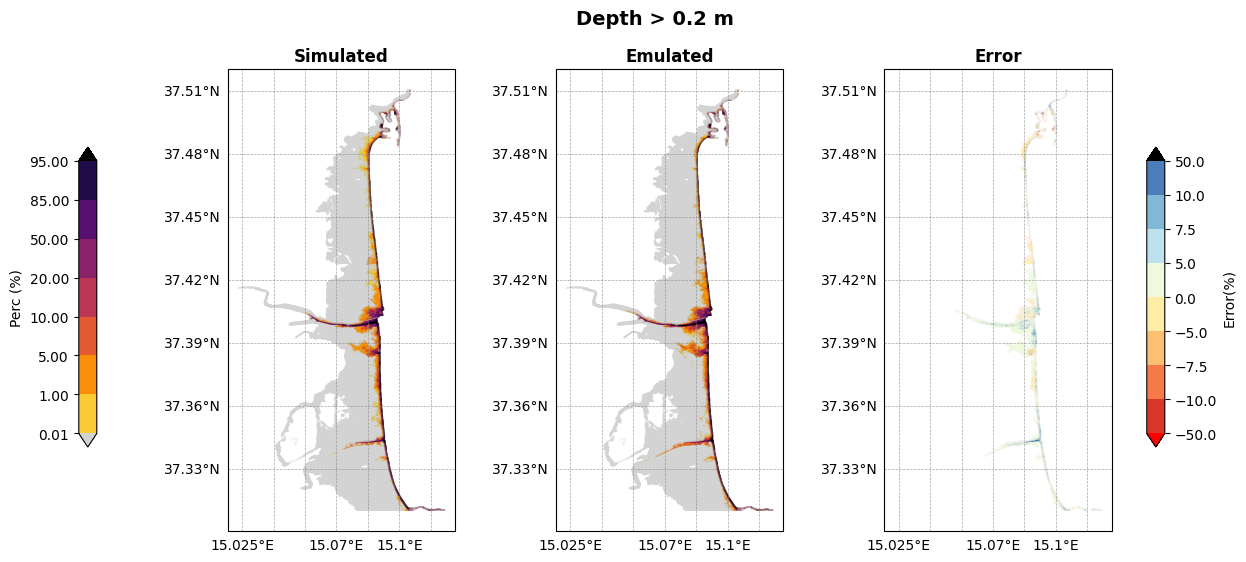

plotting for Depth:0.5

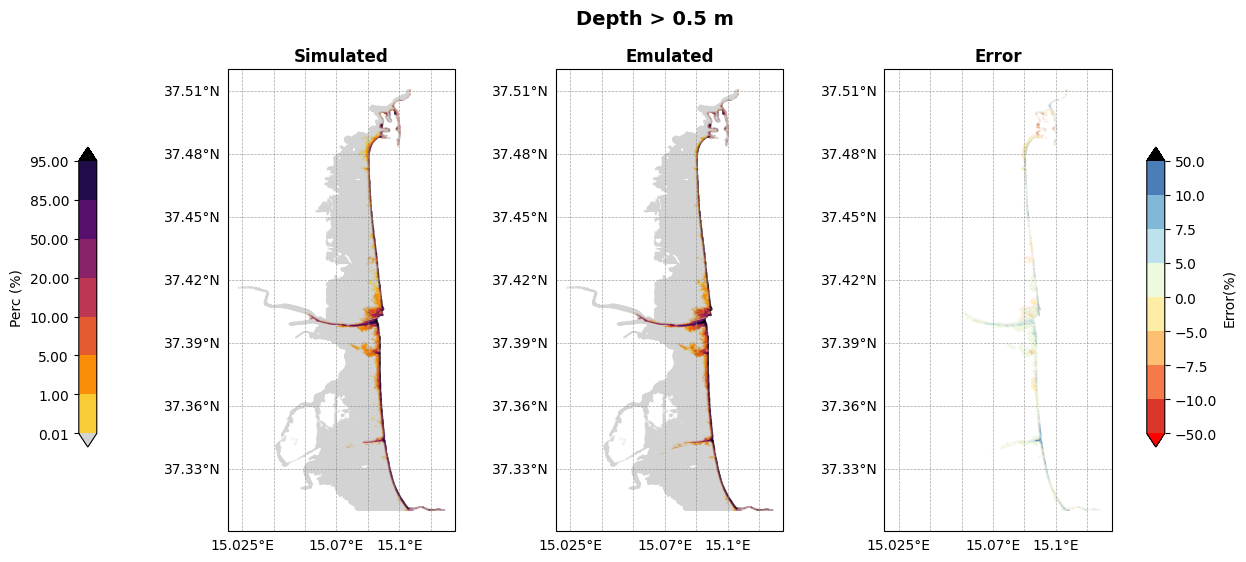

plotting for Depth:1

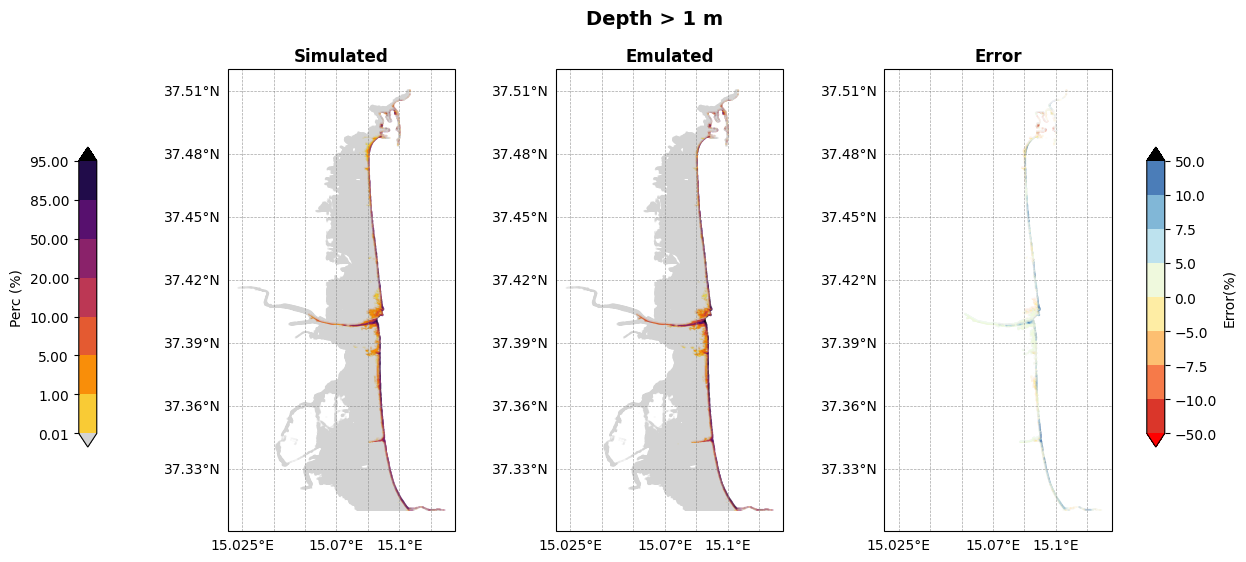

plotting for Depth:2.5

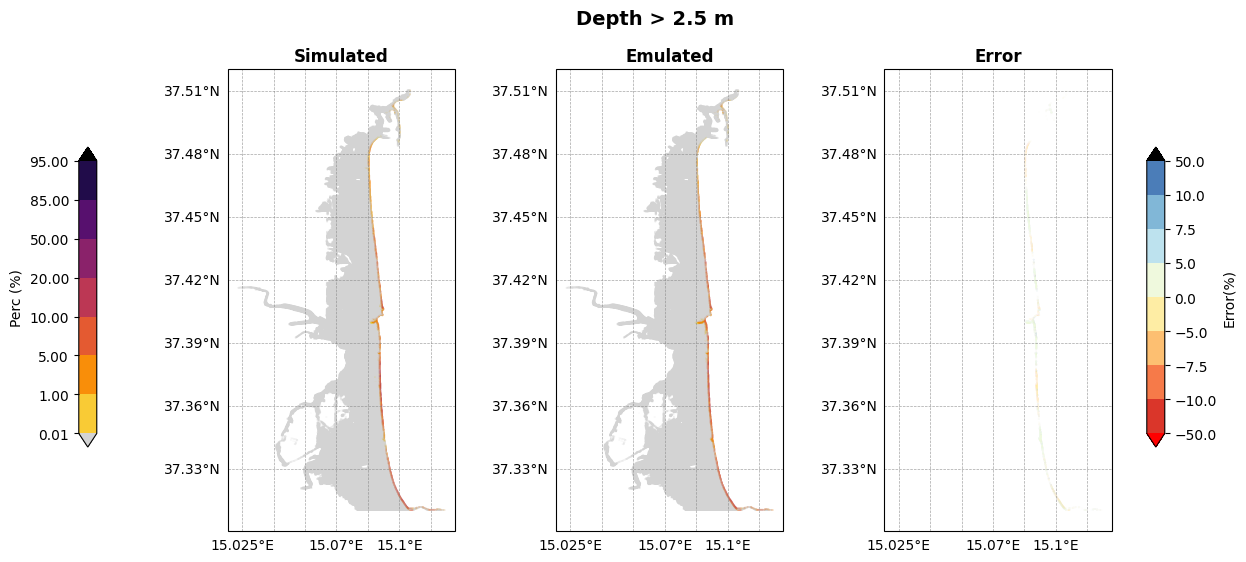

plotting for Depth:4

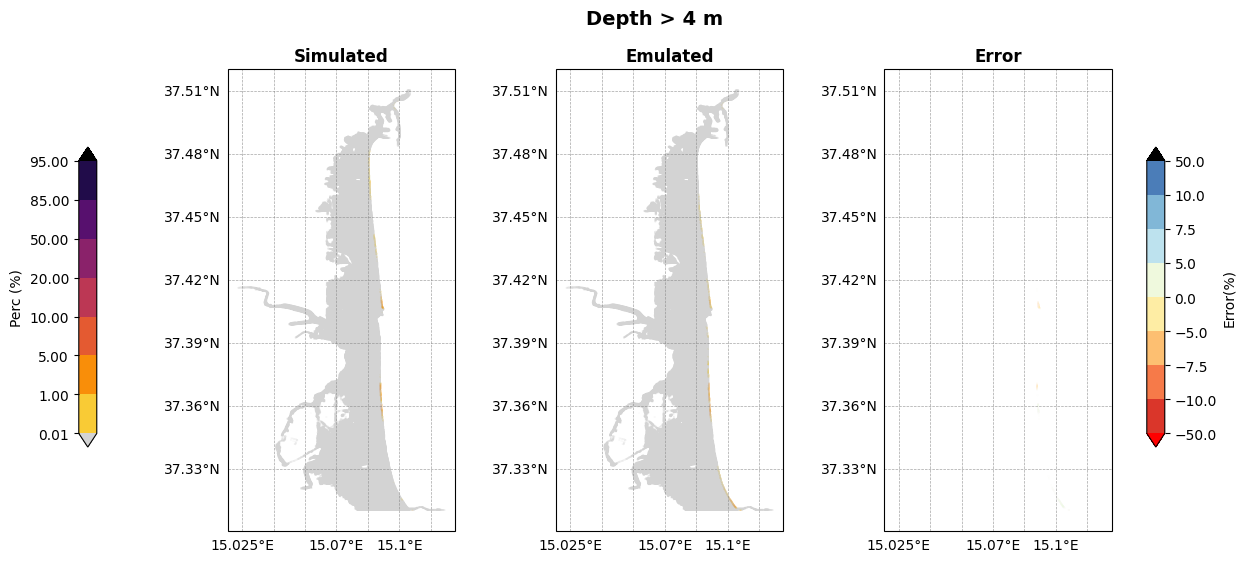

In [69]:
#plot the lat, lon, and z values as map
thresholds = [0.01, 0.2, 0.5,1,2.5,4]

# Plot predicted values as a heatmap
depth_cmap = colormaps['inferno_r']
depth_cmap.set_under('lightgrey')  # Set color for values below the minimum bound
depth_cmap.set_over('black')  # Set color for values above the maximum bound
depth_cmap.set_bad('white')  # Set color for NaN values
bounds = [0.01, 1, 5, 10 , 20, 50, 85, 95]
percnorm = colors.BoundaryNorm(bounds, depth_cmap.N, extend='both')

error_cmap = colormaps['RdYlBu']
error_bounds = [ -50, -10, -7.5, -5, 0, 5, 7.5, 10, 50]
error_cmap.set_under('red')  # Set color for values below the minimum bound
error_cmap.set_over('black')  # Set color for values above the maximum bound
error_cmap.set_bad('white')  # Set color for NaN values
error_norm = colors.BoundaryNorm(error_bounds, error_cmap.N, extend='both')

for i in range(len(thresholds)):
    print(f"plotting for Depth:{thresholds[i]}", end="", flush=True)

    index = np.where(depths == thresholds[i])[0]  # Get the index of the threshold depth

    # Define shared coordinates
    z_sim = depths_percentage.iloc[:,index].values
    z_emul = depthshat_percentage.iloc[:,index].values
    error = z_emul - z_sim  # Error map

    #id err is withing 1 % set to nan
    error[np.abs(error) <= 1] = np.nan

    # Setup figure and subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # --- Plot 1: Simulated ---
    sc0 = axs[0].scatter(lon_mask, lat_mask, c=z_sim, cmap=depth_cmap, norm=percnorm, s=0.001,  transform=ccrs.PlateCarree())
    axs[0].set_title(f"Simulated", fontsize=12, fontweight="bold")
    gl0 = axs[0].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
    gl0.top_labels = gl0.right_labels = False
    gl0.xformatter = cticker.LongitudeFormatter()
    gl0.yformatter = cticker.LatitudeFormatter()

    # --- Plot 2: Emulated ---
    sc1 = axs[1].scatter(lon_mask, lat_mask, c=z_emul, cmap=depth_cmap, norm=percnorm, s=0.001, transform=ccrs.PlateCarree())
    axs[1].set_title("Emulated", fontsize=12, fontweight="bold")
    gl1 = axs[1].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
    gl1.top_labels = gl1.right_labels = False
    gl1.xformatter = cticker.LongitudeFormatter()
    gl1.yformatter = cticker.LatitudeFormatter()

    # --- Plot 3: Error ---
    sc2 = axs[2].scatter(lon_mask, lat_mask, c=error,cmap= error_cmap, norm=error_norm, s=0.001, transform=ccrs.PlateCarree())
    axs[2].set_title("Error", fontsize=12, fontweight="bold")
    gl2 = axs[2].gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
    gl2.top_labels = gl2.right_labels = False
    gl2.xformatter = cticker.LongitudeFormatter()
    gl2.yformatter = cticker.LatitudeFormatter()

    # --- Colorbars ---
    # Depth (m) colorbar on the left of first subplot
    cbar_ax1 = fig.add_axes([0.02, 0.25, 0.015, 0.5])  
    cbar1 = fig.colorbar(sc1, cax=cbar_ax1)
    cbar1.set_label('Perc (%)')
    cbar1.ax.yaxis.set_label_position('left')
    cbar1.ax.yaxis.set_ticks_position('left')

    # Error (m) colorbar on the right of last subplot
    cbar_ax2 = fig.add_axes([0.91, 0.25, 0.015, 0.5])
    cbar2 = fig.colorbar(sc2, cax=cbar_ax2)
    cbar2.set_label('Error(%)')
    
    plt.suptitle(f"Depth > {thresholds[i]} m", fontsize=14, fontweight="bold")
    plt.savefig(f"./notebooks/_plots/plot_depth_{thresholds[i]}.png", bbox_inches='tight',dpi=300)

    plt.show()